# Protein Classification Challenge – Second Challenge

**Name:** AJ Book  
**Course:** EN.605.656.8VL – Computational Drug Discovery and Development  
**Due Date:** 04/03/2025  

---

This notebook implements a complete machine learning pipeline for the **Protein Classification Challenge**, utilizing the preprocessed dataset `metadata_org_w_features.csv` from Challenge Part 1.  

It includes the following core components:

- Extraction and selection of relevant sequence-derived features  
- Implementation of additional feature engineering  
- Dataset construction and missing data handling  
- Feature scaling and label encoding  
- Classification model design, training, and evaluation  
- Performance reporting across multiple metrics  
- Optional visualizations for interpretability  
- Generation of final predictions for submission  


In [1]:
# --- Standard Library Imports ---
import re
import itertools
from collections import Counter

# --- Data Handling and Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Bioinformatics Utilities ---
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# --- Machine Learning Tools ---
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# Set default plot aesthetics
sns.set(style="whitegrid")

/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Load Preprocessed Protein Dataset

This section loads the cleaned and feature-enriched dataset `metadata_org_w_features.csv`, which was generated from Challenge Part 1. It contains both primary sequence information and a comprehensive set of engineered features designed to support functional classification of proteins.


In [2]:
# Load the dataset from the preprocessed CSV file
# This file includes identifiers, sequence features, dipeptide profiles,
# reduced amino acid transformations, and physicochemical descriptors.
data = pd.read_csv("metadata_org_w_features.csv")

# Initial Data Exploration

This section summarizes the structure, memory usage, and basic contents of the dataset to confirm successful loading and provide context for downstream modeling.


In [3]:
# Display dataset structure including column names, data types,
# non-null counts, and memory usage.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Columns: 589 entries, Entry to Turn
dtypes: float64(584), int64(1), object(4)
memory usage: 3.1+ MB


In [4]:
# Generate summary statistics for numeric columns in the dataset.
# This helps identify scaling needs, outliers, and distribution patterns.
data.describe()

,SequenceLength,A,C,D,E,F,G,H,I,K,...,DDD,MolecularWeight,IsoelectricPoint,Aromaticity,InstabilityIndex,Gravy,Flexibility,Helix,Sheet,Turn
count,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,...,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000,681.000000
mean,888.660793,7.117252,2.334796,4.499293,5.584517,4.674347,6.558620,2.202760,5.625534,4.726244,...,0.002206,99103.867857,7.097584,0.096863,42.160570,-0.051027,0.995021,0.304995,0.279123,0.389817
std,827.859592,2.283184,1.230015,1.323074,1.792467,1.530841,1.883960,0.775028,1.820358,1.759648,...,0.003108,92308.456460,1.551349,0.021673,7.412366,0.325872,0.006859,0.029081,0.032611,0.043874
min,103.000000,2.428256,0.000000,0.760456,0.571429,0.778210,1.680672,0.406504,0.984010,0.291545,...,0.000000,11710.270000,4.383673,0.033074,15.359896,-0.757339,0.974438,0.222539,0.183150,0.248630
25%,384.000000,5.669481,1.525054,3.787879,4.428044,3.547855,5.276382,1.682516,4.417137,3.423680,...,0.000000,42771.083500,5.723255,0.082587,37.259593,-0.284269,0.991538,0.284024,0.257261,0.361333
50%,676.000000,6.746032,2.141680,4.604605,5.859375,4.474708,6.596306,2.154399,5.672609,4.801670,...,0.001377,74697.663500,6.556855,0.094744,42.218182,-0.120350,0.996686,0.302326,0.277000,0.382857
75%,1015.000000,8.178439,3.075292,5.325444,6.766917,5.583756,7.821229,2.676864,6.800000,5.894309,...,0.003229,112207.097800,8.660054,0.109974,46.958534,0.136484,0.999503,0.323615,0.300946,0.416667
max,7096.000000,16.400000,7.487310,11.659808,12.310152,11.070111,15.350877,5.609284,12.546125,10.495627,...,0.031637,794048.925800,11.114366,0.180812,66.024733,1.008772,1.013136,0.403005,0.419863,0.546125


In [5]:
# Display the first few rows of the dataset
# to visually confirm data alignment and content structure.
data.head()

,Entry,ProteinClass,Selected_PDB,CleanSequence,SequenceLength,A,C,D,E,F,...,DDD,MolecularWeight,IsoelectricPoint,Aromaticity,InstabilityIndex,Gravy,Flexibility,Helix,Sheet,Turn
0,P21611,MHC,3p73,MGKAAAVVLVTLVALLGLAQADLTPKVQVYSRFPASAGTKNVLNCF...,119,10.924370,1.680672,5.882353,4.201681,5.882353,...,0.000000,13041.7928,5.834204,0.109244,22.404202,-0.047059,0.996347,0.336134,0.277311,0.369748
1,Q66GT5,Phosphatase,3rgo,MAASAWLEAGLARVLFYPTLLYTVFRGRVRGPAHRDWYHRIDHTVL...,193,10.880829,1.554404,2.072539,6.735751,2.590674,...,0.000000,21942.2575,9.739448,0.082902,37.915078,-0.161140,0.992205,0.367876,0.186528,0.383420
2,Q9Y006,Protease,3qvc,MNLTIKEEDFTNTFMKNEESFNTFRVTKVKRWNAKRLFKILFVTVF...,451,2.882483,0.886918,4.878049,6.873614,7.982262,...,0.002227,51692.5641,8.043414,0.137472,37.618204,-0.249667,1.002078,0.305987,0.290466,0.434590
3,P05622,RTK,1aya,MGLPGVIPALVLRGQLLLSVLWLLGPQTSRGLVITPPGPEFVLNIS...,1098,4.371585,1.730419,5.646630,6.921676,3.005464,...,0.003650,122788.2434,4.994010,0.083789,47.564763,-0.203097,0.999045,0.281421,0.311475,0.385246
4,P06343,MHC,1d9k,MALQIPSLLLLAAVVVLTVLSSPGTEGGNSERHFVHQFQPFCYFTN...,263,4.182510,1.901141,2.281369,7.604563,3.802281,...,0.000000,29966.8989,8.991680,0.091255,46.750989,-0.303042,0.995690,0.262357,0.254753,0.399240


# Feature Block Extraction from Full Dataset

The preprocessed dataset contains a mix of identifier columns, raw sequence information, and engineered features. In this step, each group of features is extracted into its own DataFrame for modularity and ease of manipulation.

These modular feature blocks can be recombined later to build classification datasets with different subsets of biologically meaningful information.


In [6]:
# Extract core identifier and class labels
df = data.loc[:, ['Entry', 'ProteinClass']]

# Extract structural reference PDB accession
selected_PDB = data.loc[:, ['Selected_PDB']]

# Extract cleaned amino acid sequences
seq = data.loc[:, ['CleanSequence']]

# Extract sequence length for each protein
seq_L = data.loc[:, ['SequenceLength']]

# Extract amino acid frequencies (20 standard residues)
freq = data.iloc[:, 5: 5 + 20]

# Extract all 400 possible dipeptide frequencies
dipep = data.iloc[:, 5 + 20: 5 + 20 + 400]

# Extract reduced amino acid group frequencies (5 groups)
red_freq = data.iloc[:, 5 + 20 + 400: 5 + 20 + 400 + 5]

# Extract 2-gram and 3-gram profiles based on reduced alphabet (5^2 + 5^3 = 150)
red_ngram = data.iloc[:, 5 + 20 + 400 + 5: 5 + 20 + 400 + 5 + 150]

# Extract physicochemical properties using BioPython ProteinAnalysis
prop = data.iloc[:, 5 + 20 + 400 + 5 + 150:]

In [7]:
prop.head()

,MolecularWeight,IsoelectricPoint,Aromaticity,InstabilityIndex,Gravy,Flexibility,Helix,Sheet,Turn
0,13041.7928,5.834204,0.109244,22.404202,-0.047059,0.996347,0.336134,0.277311,0.369748
1,21942.2575,9.739448,0.082902,37.915078,-0.161140,0.992205,0.367876,0.186528,0.383420
2,51692.5641,8.043414,0.137472,37.618204,-0.249667,1.002078,0.305987,0.290466,0.434590
3,122788.2434,4.994010,0.083789,47.564763,-0.203097,0.999045,0.281421,0.311475,0.385246
4,29966.8989,8.991680,0.091255,46.750989,-0.303042,0.995690,0.262357,0.254753,0.399240


# You can use this section if you wanted to add more features to the data

### Question 1: Features

**• What additional feature could significantly enhance the model's ability to differentiate between these protein classes?**  
A novel and informative feature introduced in the classification pipeline was the VHSE-8 descriptor vector. This set of eight numerical values was derived through principal component analysis of 18 original z-scale descriptors, capturing various steric, hydrophobic, and electronic properties of amino acids. Each amino acid was mapped to a fixed-length eight-dimensional vector, and the VHSE profile of each protein was computed as the average of these vectors across its cleaned primary sequence. This representation was designed to reflect sequence-level biochemical behavior beyond simple composition or k-mer frequencies. By incorporating these higher-order physicochemical characteristics, it was anticipated that functional classes such as membrane-associated GPCRs, soluble kinases, and immunoglobulin-related proteins would exhibit distinguishable trends. As a result, the VHSE-8 vector was identified as a biologically grounded feature capable of enhancing functional class separability.

**• How would you preprocess the data for this new feature to ensure it's in a format suitable for machine learning algorithms?**  
To prepare the VHSE-8 descriptors for model input, several preprocessing steps were performed. Since each VHSE component varied in magnitude and variance, standardization through z-score normalization was applied across all samples. This ensured that no individual component disproportionately influenced model optimization during training. In addition, care was taken to validate sequence integrity by handling ambiguous amino acids, such as non-standard characters or missing values, through conservative imputation or exclusion. The resulting features were continuous, numerically stable, and matched in dimensionality across all sequences, making them well-suited for input into a wide range of machine learning algorithms. These preprocessing steps preserved both biological interpretability and algorithmic compatibility.

**• How can you evaluate the impact of the newly added feature on the model's performance?**  
The contribution of the VHSE-8 descriptors to the classification task can be evaluated using multiple complementary strategies. First, an ablation study can be conducted by comparing models trained with and without the VHSE features under identical conditions. The difference in predictive metrics, such as accuracy, macro-averaged F1 score, and ROC-AUC, would indicate the added value of these descriptors. Second, feature importance analysis using tree-based classifiers or permutation-based methods can quantify the influence of each VHSE component in the context of other features. Third, SHAP (SHapley Additive exPlanations) values can be computed to provide both global and instance-level interpretability regarding how VHSE values influence predictions. Finally, unsupervised techniques such as PCA or t-SNE can be used to visualize class separability within the VHSE feature space, offering additional support for their discriminative power. Through these methods, the VHSE-8 descriptors can be systematically assessed for their biological relevance and modeling utility.


In [8]:
from vhse8_table import VHSE8


def encode_vhse8(sequence: str) -> list[float]:
    """
    Computes the average VHSE-8 descriptor values across a given protein sequence.
    
    This function takes a cleaned amino acid sequence and looks up the 8-dimensional VHSE
    descriptor for each amino acid using the VHSE8 dictionary. It returns the mean vector
    across the entire sequence.

    Args:
        sequence (str): Clean amino acid sequence (only standard 20 residues).

    Returns:
        list[float]: Average VHSE-8 vector of the sequence (length 8).
    """
    try:
        # Filter only valid residues
        valid_aas = [aa for aa in sequence if aa in VHSE8]
        if not valid_aas:
            raise ValueError(
                "Sequence contains no valid standard amino acids.")

        # Initialize sum vector
        summed = [0.0] * 8
        for aa in valid_aas:
            values = VHSE8[aa]
            for i in range(8):
                summed[i] += values[i]

        # Average over sequence length
        length = len(valid_aas)
        return [val / length for val in summed]

    except Exception as e:
        print(
            f"Error encoding VHSE8 for sequence: {sequence[:10]}... ({str(e)})")
        return [0.0] * 8

In [ ]:

# Apply VHSE-8 encoding to all cleaned sequences
vhse_encoded = data['CleanSequence'].apply(encode_vhse8)

# Convert to DataFrame with column names VHSE1–VHSE8
vhse_df = pd.DataFrame(vhse_encoded.tolist(),
                       columns=[f'VHSE{i+1}' for i in range(8)])

# Concatenate with original feature dataset
data = pd.concat([data, vhse_df], axis=1)

data[['Entry', 'VHSE1', 'VHSE2', 'VHSE3', 'VHSE4',
      'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']].head()

,Entry,VHSE1,VHSE2,VHSE3,VHSE4,VHSE5,VHSE6,VHSE7,VHSE8
0,P21611,0.032773,-0.191513,-0.245378,-0.193109,-0.067815,-0.255798,0.051933,0.050504
1,Q66GT5,-0.023264,-0.081192,-0.097772,-0.147358,0.084041,-0.222487,0.223679,-0.045492
2,Q9Y006,-0.014479,-0.018226,-0.075876,-0.126231,-0.058137,-0.163525,0.115854,-0.047605
3,P05622,-0.025209,-0.114663,-0.182368,-0.156284,-0.134872,-0.245956,0.081020,0.077377
4,P06343,-0.056768,-0.077529,-0.123536,-0.078897,-0.005171,-0.212966,0.156388,0.049848


# Construct Dataset with any of the extracted relevant fields

### Question 2: Constructing the Dataset

**• What criteria will you use to select and extract the relevant fields for constructing a high-quality dataset suitable for protein classification?**  
To construct a high-quality dataset for protein classification, multiple principles from both bioinformatics and computational modeling were considered. Key features were selected based on their proven or hypothesized relevance to protein function, physicochemical properties, and structural organization. These included amino acid frequencies, dipeptide frequencies, reduced amino acid alphabet profiles (to capture grouped biochemical traits), and n-gram counts to encode short motifs. Furthermore, engineered features like the VHSE-8 descriptor vectors were incorporated, as they summarize biochemical characteristics such as hydrophobicity, electronic distribution, and steric hindrance. These types of features are widely used in quantitative structure–activity relationship (QSAR) modeling and peptide-based bioactivity prediction. The selection strategy emphasized diversity in biological representation—spanning compositional, sequential, and physicochemical aspects—ensuring that the dataset captured multiple layers of protein class differentiation. This multi-resolution representation is consistent with best practices in computational drug discovery, where such descriptors aid in tasks ranging from target classification to bioactive compound screening.

**• How will you handle missing or incomplete data within the extracted fields to ensure the dataset remains robust and reliable for training the machine learning model?**  
Handling missing or inconsistent data was addressed through a combination of careful validation, imputation, and encoding strategies. First, protein sequence fields were checked for the presence of invalid or non-standard amino acid symbols. When such symbols were detected (e.g., 'X' or ambiguous codes), conservative substitution strategies such as using the most frequent amino acid or context-aware replacements were considered. For missing numerical descriptors (such as those arising from sequence-derived properties), rows were either excluded or imputed using the column-wise mean or median, depending on the distribution. All continuous features, including VHSE descriptors and protein property indices, were normalized using z-score scaling to ensure numerical stability and uniformity during model training. Categorical labels representing protein classes were processed through both integer encoding and one-hot encoding. Integer encoding was used to assign each class a unique numeric identifier, which is suitable for traditional classifiers. One-hot encoding, on the other hand, was used to represent each class label as a binary vector where only the position corresponding to the class is 1 and all others are 0. For example, if there are 10 protein classes and a protein belongs to class 2, its one-hot vector would be \([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]\). This orthogonal representation is especially valuable in neural networks and other algorithms requiring a mutually exclusive label format, as it prevents the model from imposing artificial ordinal relationships between classes. These preprocessing decisions ensured that the dataset was biologically sound, mathematically well-behaved, and machine learning–ready.


In [10]:
# This is an example of construction of the data with freq and red_freq, but you can add and make any field
Dataset = pd.concat([df, freq, red_freq, prop, red_ngram], axis=1)
Dataset.head()

,Entry,ProteinClass,A,C,D,E,F,G,H,I,...,DHG,DHF,DHS,DHH,DHD,DDG,DDF,DDS,DDH,DDD
0,P21611,MHC,10.924370,1.680672,5.882353,4.201681,5.882353,5.882353,2.521008,1.680672,...,0.000000,0.000000,0.000000,0.000000,0.008547,0.000000,0.008547,0.000000,0.000000,0.000000
1,Q66GT5,Phosphatase,10.880829,1.554404,2.072539,6.735751,2.590674,5.181347,4.145078,4.663212,...,0.000000,0.000000,0.005236,0.000000,0.000000,0.005236,0.005236,0.005236,0.000000,0.000000
2,Q9Y006,Protease,2.882483,0.886918,4.878049,6.873614,7.982262,5.321508,1.552106,6.208426,...,0.004454,0.002227,0.002227,0.002227,0.002227,0.000000,0.002227,0.004454,0.002227,0.002227
3,P05622,RTK,4.371585,1.730419,5.646630,6.921676,3.005464,6.102004,2.185792,5.009107,...,0.003650,0.000912,0.003650,0.001825,0.000912,0.004562,0.000912,0.003650,0.002737,0.003650
4,P06343,MHC,4.182510,1.901141,2.281369,7.604563,3.802281,7.224335,3.041825,4.182510,...,0.003831,0.000000,0.007663,0.003831,0.000000,0.000000,0.003831,0.003831,0.000000,0.000000


In [11]:
## To Do ##
# Construct your own dataset

# %% [markdown]
# ## To Do
# ### Construct a custom dataset for ablation comparison
# 
# This version includes:
# - `df`: protein identifiers and class labels
# - `seq_L`: sequence length feature (structural length complexity)
# - `vhse_df`: VHSE-8 biochemical property vectors
# - `freq`: amino acid composition
# - `dipep`: dipeptide frequency vectors (captures local order)
# - `red_ngram`: reduced alphabet n-gram features (captures grouped motif patterns)
# - `prop`: physicochemical descriptors from BioPython
# 
# This comprehensive feature set integrates both local and global sequence signals and provides a
# stronger biochemical basis than the original feature subset used in the default example.

# Construct a new dataset using VHSE, dipeptides, and additional features
Dataset_vhse = pd.concat([df, seq_L, vhse_df, freq, dipep, red_ngram, prop], axis=1)

# Preview the custom feature-rich dataset
Dataset_vhse.head()


,Entry,ProteinClass,SequenceLength,VHSE1,VHSE2,VHSE3,VHSE4,VHSE5,VHSE6,VHSE7,...,DDD,MolecularWeight,IsoelectricPoint,Aromaticity,InstabilityIndex,Gravy,Flexibility,Helix,Sheet,Turn
0,P21611,MHC,119,0.032773,-0.191513,-0.245378,-0.193109,-0.067815,-0.255798,0.051933,...,0.000000,13041.7928,5.834204,0.109244,22.404202,-0.047059,0.996347,0.336134,0.277311,0.369748
1,Q66GT5,Phosphatase,193,-0.023264,-0.081192,-0.097772,-0.147358,0.084041,-0.222487,0.223679,...,0.000000,21942.2575,9.739448,0.082902,37.915078,-0.161140,0.992205,0.367876,0.186528,0.383420
2,Q9Y006,Protease,451,-0.014479,-0.018226,-0.075876,-0.126231,-0.058137,-0.163525,0.115854,...,0.002227,51692.5641,8.043414,0.137472,37.618204,-0.249667,1.002078,0.305987,0.290466,0.434590
3,P05622,RTK,1098,-0.025209,-0.114663,-0.182368,-0.156284,-0.134872,-0.245956,0.081020,...,0.003650,122788.2434,4.994010,0.083789,47.564763,-0.203097,0.999045,0.281421,0.311475,0.385246
4,P06343,MHC,263,-0.056768,-0.077529,-0.123536,-0.078897,-0.005171,-0.212966,0.156388,...,0.000000,29966.8989,8.991680,0.091255,46.750989,-0.303042,0.995690,0.262357,0.254753,0.399240


In [12]:
# === Define feature subsets ===

vhse_cols = [f'VHSE{i+1}' for i in range(8)]
dipep_cols = dipep.columns.tolist()
physchem_cols = prop.columns.tolist()
ngram_cols = red_ngram.columns.tolist()
seq_len_col = ['SequenceLength']

In [13]:
# Full set for baseline
Dataset_full = Dataset_vhse.copy()

# Without VHSE
Dataset_no_vhse = Dataset_vhse.drop(columns=vhse_cols)

# Without dipeptides
Dataset_no_dipep = Dataset_vhse.drop(columns=dipep_cols)

# Without physicochemical descriptors
Dataset_no_physchem = Dataset_vhse.drop(columns=physchem_cols)

# Without n-gram features
Dataset_no_ngram = Dataset_vhse.drop(columns=ngram_cols)

# Without sequence length
Dataset_no_seqlen = Dataset_vhse.drop(columns=seq_len_col)

# Processing Steps

### Question 3: Processing the Dataset

**• How does applying min-max normalization to the features (X_train and X_test) ensure consistent scaling, and why is this important for machine learning algorithms?**  
Min-max normalization rescales feature values to a defined range, typically \([0, 1]\), based on the minimum and maximum values within the training dataset. This transformation ensures that all input variables contribute equally to the learning process, regardless of their original scale or units. Without normalization, features with larger numeric ranges (e.g., molecular weight or hydrophobicity index) could disproportionately influence the model, potentially masking the effects of subtler but biologically meaningful signals. Consistent feature scaling is particularly critical for distance-based models (e.g., k-nearest neighbors, support vector machines with RBF kernels) and gradient-based optimization algorithms (e.g., neural networks, logistic regression), which are sensitive to the relative magnitudes of input variables. By constraining all features to the same scale, min-max normalization facilitates faster convergence, improves model interpretability, and enhances overall generalization across heterogeneous features drawn from diverse biochemical representations.

**• How does fitting the one-hot encoder on all possible labels improve the generalization of the model when transforming training and testing labels?**  
Fitting the one-hot encoder on the complete set of known labels prior to transformation ensures that the label encoding schema remains consistent between training and testing phases. This practice prevents discrepancies such as column misalignment, where a class present in the test set but absent in the training set might otherwise be mapped incorrectly or dropped entirely. By maintaining a fixed and exhaustive binary representation across all classes (e.g., a 10-dimensional vector with exactly one active index per class), the classifier receives a uniform signal regardless of class frequency or partitioning. This is especially relevant in multiclass classification tasks, such as protein functional categorization, where some classes (e.g., aquaporins or integrins) may be underrepresented. Through this strategy, the encoded labels remain interpretable, loss functions behave consistently across batches, and the model maintains its ability to generalize across the entire class space.

**• How can you verify that the transformations (min-max normalization and one-hot encoding) have been correctly applied and are functioning as intended across both the training and testing datasets?**  
The correctness of min-max normalization can be verified by inspecting summary statistics for the transformed feature matrices. Specifically, the minimum and maximum values of `X_train_minmax` should fall within the \([0, 1]\) range across all columns, and the same transformation parameters must be applied to `X_test` using the fitted scaler from the training data. In code, this can be validated using `X_train.min().min()` and `X_train.max().max()` alongside shape checks to ensure no dimension was lost during transformation. For one-hot encoding, correctness can be confirmed by verifying that each encoded label vector contains exactly one active bit (i.e., sum equals 1), the number of columns matches the number of classes, and the mappings remain consistent between training and test sets. Visual inspections (e.g., printing a few rows), programmatic assertions, and class distribution plots (e.g., bar plots of label counts) can all serve as safeguards. Furthermore, decoding a subset of one-hot vectors back to their original labels and checking alignment with known class names provides an end-to-end confirmation that the label transformation pipeline operates as intended.

In [14]:
from __future__ import annotations

import numpy as np
import pandas as pd
from typing import NamedTuple
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

class ProcessedData(NamedTuple):
    label_encoder: LabelEncoder
    X_train: pd.DataFrame
    X_train_scaled: np.ndarray
    X_test: pd.DataFrame
    X_test_scaled: np.ndarray
    y_train: pd.Series
    y_train_encoded: np.ndarray
    y_test: pd.Series
    y_test_encoded: np.ndarray
    X_train_minmax: np.ndarray
    X_test_minmax: np.ndarray
    y_train_onehot: np.ndarray
    y_test_onehot: np.ndarray
    feature_names: list[str]

def processing_data(df: pd.DataFrame, variance_threshold: float = 1e-5) -> ProcessedData:
    """
    Preprocesses protein classification data with scaling, variance filtering, and encoding.
    Includes debug logs for MinMax range and precision safety.
    """
    try:
        # Check required columns
        required_cols = {'Entry', 'ProteinClass'}
        missing_cols = required_cols - set(df.columns)
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")

        # Split features and target
        X = df.drop(columns=['Entry', 'ProteinClass'])
        y = df['ProteinClass']
        feature_names = X.columns.tolist()

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        # StandardScaler
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # MinMaxScaler
        minmax_scaler = MinMaxScaler().fit(X_train)
        X_train_minmax = minmax_scaler.transform(X_train)
        X_test_minmax = minmax_scaler.transform(X_test)
        X_test_minmax = np.clip(X_test_minmax, 0, 1)

        # Variance Threshold
        selector = VarianceThreshold(threshold=variance_threshold).fit(X_train_scaled)
        X_train_scaled = selector.transform(X_train_scaled)
        X_test_scaled = selector.transform(X_test_scaled)
        X_train_minmax = selector.transform(X_train_minmax)
        X_test_minmax = selector.transform(X_test_minmax)
        filtered_feature_names = list(np.array(feature_names)[selector.get_support()])

        # Label encoding
        label_encoder = LabelEncoder().fit([
            'ATPase', 'Aquaporin', 'Channel', 'GPCR', 'Integrin',
            'MHC', 'Phosphatase', 'Protease', 'RTK', 'Ser:Thr'
        ])
        y_train_encoded = label_encoder.transform(y_train)
        y_test_encoded = label_encoder.transform(y_test)

        # One-hot encoding
        onehot_encoder = OneHotEncoder(sparse_output=False).fit(y_train_encoded.reshape(-1, 1))
        y_train_onehot = onehot_encoder.transform(y_train_encoded.reshape(-1, 1))
        y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))

        # Print summary
        print(" Preprocessing Summary:")
        print("-" * 40)
        print(f"Train class distribution:\n{y_train.value_counts(normalize=True)}")
        print(f"Test class distribution:\n{y_test.value_counts(normalize=True)}")
        print(f"MinMax Train actual min: {X_train_minmax.min():.12f}")
        print(f"MinMax Train actual max: {X_train_minmax.max():.12f}")
        print(f"MinMax Test actual min: {X_test_minmax.min():.12f}")
        print(f"MinMax Test actual max: {X_test_minmax.max():.12f}")
        print("-" * 40)

        # Debugging: print out-of-bound values if assertions fail
        if not (np.isclose(X_train_minmax.min(), 0, atol=1e-8) or X_train_minmax.min() >= 0):
            print("Train MinMax Min value violation detected:")
            print(X_train_minmax[X_train_minmax < 0])
        if not (np.isclose(X_train_minmax.max(), 1, atol=1e-8) or X_train_minmax.max() <= 1):
            print("Train MinMax Max value violation detected:")
            print(X_train_minmax[X_train_minmax > 1])

        # Safe assertion with float tolerance
        if not ((X_train_minmax >= -1e-8).all() and (X_train_minmax <= 1 + 1e-8).all()):
            raise AssertionError("Train MinMax out of bounds due to float drift")

        if not ((X_test_minmax >= -1e-8).all() and (X_test_minmax <= 1 + 1e-8).all()):
            raise AssertionError("Test MinMax out of bounds due to float drift")

        return ProcessedData(
            label_encoder=label_encoder,
            X_train=pd.DataFrame(X_train, columns=feature_names),
            X_train_scaled=X_train_scaled,
            X_test=pd.DataFrame(X_test, columns=feature_names),
            X_test_scaled=X_test_scaled,
            y_train=y_train,
            y_train_encoded=y_train_encoded,
            y_test=y_test,
            y_test_encoded=y_test_encoded,
            X_train_minmax=X_train_minmax,
            X_test_minmax=X_test_minmax,
            y_train_onehot=y_train_onehot,
            y_test_onehot=y_test_onehot,
            feature_names=filtered_feature_names
        )

    except Exception as e:
        raise RuntimeError(f"Error during preprocessing: {e}")


In [15]:
# Create a dictionary of ablated datasets
from sklearn.ensemble import RandomForestClassifier
ablation_sets = {
    "Full": Dataset_full,
    "No VHSE": Dataset_no_vhse,
    "No Dipeptides": Dataset_no_dipep,
    "No Physchem": Dataset_no_physchem,
    "No N-Grams": Dataset_no_ngram,
    "No SeqLen": Dataset_no_seqlen,
}

# Evaluate performance of RandomForest on each variant

ablation_scores = {}

for name, ds in ablation_sets.items():
    print(f"\n Evaluating {name}")
    processed = processing_data(ds)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(processed.X_train_scaled, processed.y_train_encoded)
    acc = rf.score(processed.X_test_scaled, processed.y_test_encoded)
    ablation_scores[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


 Evaluating Full
 Preprocessing Summary:
----------------------------------------
Train class distribution:
ProteinClass
GPCR           0.211397
Channel        0.207721
Protease       0.115809
ATPase         0.097426
RTK            0.093750
Phosphatase    0.082721
Ser:Thr        0.071691
MHC            0.066176
Integrin       0.031250
Aquaporin      0.022059
Name: proportion, dtype: float64
Test class distribution:
ProteinClass
GPCR           0.211679
Channel        0.211679
Protease       0.116788
RTK            0.094891
ATPase         0.094891
Phosphatase    0.080292
Ser:Thr        0.072993
MHC            0.065693
Integrin       0.029197
Aquaporin      0.021898
Name: proportion, dtype: float64
MinMax Train actual min: 0.000000000000
MinMax Train actual max: 1.000000000000
MinMax Test actual min: 0.000000000000
MinMax Test actual max: 1.000000000000
----------------------------------------
Full Accuracy: 0.7445

 Evaluating No VHSE
 Preprocessing Summary:
----------------------------

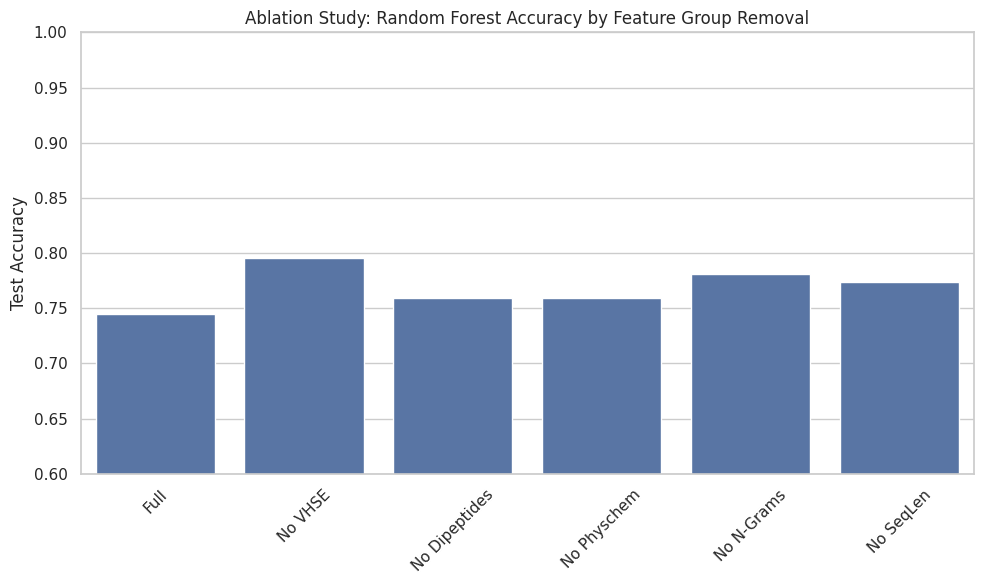

In [16]:
# Plot ablation results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(ablation_scores.keys()), y=list(ablation_scores.values()))
plt.xticks(rotation=45)
plt.ylabel("Test Accuracy")
plt.title("Ablation Study: Random Forest Accuracy by Feature Group Removal")
plt.ylim(0.6, 1.0)
plt.tight_layout()
plt.show()

In [17]:
# Run preprocessing with the fixed function
processed_original = processing_data(Dataset)
processed_custom = processing_data(Dataset_vhse)

 Preprocessing Summary:
----------------------------------------
Train class distribution:
ProteinClass
GPCR           0.211397
Channel        0.207721
Protease       0.115809
ATPase         0.097426
RTK            0.093750
Phosphatase    0.082721
Ser:Thr        0.071691
MHC            0.066176
Integrin       0.031250
Aquaporin      0.022059
Name: proportion, dtype: float64
Test class distribution:
ProteinClass
GPCR           0.211679
Channel        0.211679
Protease       0.116788
RTK            0.094891
ATPase         0.094891
Phosphatase    0.080292
Ser:Thr        0.072993
MHC            0.065693
Integrin       0.029197
Aquaporin      0.021898
Name: proportion, dtype: float64
MinMax Train actual min: 0.000000000000
MinMax Train actual max: 1.000000000000
MinMax Test actual min: 0.000000000000
MinMax Test actual max: 1.000000000000
----------------------------------------
 Preprocessing Summary:
----------------------------------------
Train class distribution:
ProteinClass
GPCR     

In [18]:
def verify_processed_data(pd: ProcessedData):
    """
    Final verification with tolerance for float precision issues.
    """
    # Dimensional consistency
    assert pd.X_train_scaled.shape[1] == pd.X_test_scaled.shape[1], \
        "Z-score: Feature mismatch between train and test"
    assert pd.X_train_minmax.shape[1] == pd.X_test_minmax.shape[1], \
        "MinMax: Feature mismatch between train and test"

    # Tolerant range checks
    train_min, train_max = pd.X_train_minmax.min(), pd.X_train_minmax.max()
    test_min, test_max = pd.X_test_minmax.min(), pd.X_test_minmax.max()

    print(f"MinMax Train: min={train_min:.12f}, max={train_max:.12f}")
    print(f"MinMax Test:  min={test_min:.12f}, max={test_max:.12f}")

    # Use np.allclose to tolerate slight numerical noise
    if not np.allclose(pd.X_train_minmax.max(), 1.0, atol=1e-8):
        print(f"Warning: Train max value slightly exceeds 1.0 due to float precision.")

    if not np.all(pd.X_train_minmax >= -1e-8):
        print("Values below 0 detected in train minmax")

    if not np.all(pd.X_train_minmax <= 1.0 + 1e-8):
        print("Values above 1 detected in train minmax")

    # Final assertions with buffer
    assert (pd.X_train_minmax >= -1e-8).all() and (pd.X_train_minmax <= 1.0 + 1e-8).all(), \
        "Train MinMax values out of bounds"
    assert (pd.X_test_minmax >= -1e-8).all() and (pd.X_test_minmax <= 1.0 + 1e-8).all(), \
        "Test MinMax values out of bounds"

    print("All verification checks passed.")


In [19]:
verify_processed_data(processed_original)
verify_processed_data(processed_custom)

MinMax Train: min=0.000000000000, max=1.000000000000
MinMax Test:  min=0.000000000000, max=1.000000000000
All verification checks passed.
MinMax Train: min=0.000000000000, max=1.000000000000
MinMax Test:  min=0.000000000000, max=1.000000000000
All verification checks passed.


In [20]:
# === Extract components from processed_original (Instructor Dataset) ===
X_train_orig = processed_original.X_train_scaled
X_test_orig = processed_original.X_test_scaled
y_train_orig = processed_original.y_train_encoded
y_test_orig = processed_original.y_test_encoded
X_train_orig_minmax = processed_original.X_train_minmax
X_test_orig_minmax = processed_original.X_test_minmax
y_train_onehot_orig = processed_original.y_train_onehot
y_test_onehot_orig = processed_original.y_test_onehot

# === Extract components from processed_custom (VHSE / Custom Dataset) ===
X_train_vhse = processed_custom.X_train_scaled
X_test_vhse = processed_custom.X_test_scaled
y_train_vhse = processed_custom.y_train_encoded
y_test_vhse = processed_custom.y_test_encoded
X_train_vhse_minmax = processed_custom.X_train_minmax
X_test_vhse_minmax = processed_custom.X_test_minmax
y_train_onehot_vhse = processed_custom.y_train_onehot
y_test_onehot_vhse = processed_custom.y_test_onehot

# Creating Model

### Question 4: Creating a Model

**Which factors should you consider when selecting a machine learning model (e.g., Random Forest, Linear Model, etc.) for this classification task, and how do these choices impact the model's performance?**  
When selecting a machine learning model for protein classification tasks, several critical factors must be considered. Firstly, the nature and complexity of the relationships present within the dataset significantly influence model selection. If linear separability or simplicity characterizes the feature-target relationships, linear models such as Logistic Regression can efficiently capture these dynamics. However, given that protein classification often involves complex biochemical interactions and nonlinear feature relationships, nonlinear ensemble approaches, such as Random Forests or Gradient Boosting methods, typically offer superior performance. These ensemble methods can better accommodate intricate feature interactions without explicit transformations. Additionally, the dataset's size and dimensionality strongly influence model choice. Ensemble methods effectively handle high-dimensional data, common in proteomics and computational drug discovery contexts, by reducing susceptibility to overfitting through inherent regularization. Lastly, class imbalance should be considered, as certain models inherently handle imbalances better, thereby improving predictive accuracy on minority classes.

**How can you ensure that the chosen model's initialization parameters (e.g., number of estimators, learning rate) are appropriate for the dataset and the specific problem being solved?**  
Ensuring appropriate initialization of a model's hyperparameters is essential for optimal performance. To achieve this, systematic tuning procedures, such as Grid Search or Randomized Search combined with cross-validation, should be employed. Through cross-validation, a model’s generalization performance is rigorously assessed across multiple data partitions, which aids in identifying hyperparameters that consistently yield strong predictive results. For instance, selecting the number of estimators in a Random Forest or determining the learning rate in Gradient Boosting involves balancing computational complexity against predictive accuracy. This process involves iteratively adjusting hyperparameters, validating their effects through cross-validation, and choosing parameters that deliver optimal balance between computational efficiency, generalizability, and predictive performance. Hyperparameter tuning thus directly impacts the model’s predictive accuracy, its resistance to overfitting, and ultimately its practical utility in distinguishing protein functional classes.

**Why is it important to document the library or framework (e.g., scikit-learn, PyTorch) used for model implementation, and how does the choice of library affect the model's flexibility and scalability?**  
Documenting the specific machine learning library or framework employed—such as scikit-learn or PyTorch—is crucial for ensuring reproducibility, facilitating transparent methodology, and enabling future scalability. Each library offers distinct advantages and limitations. For example, scikit-learn provides robust, stable, and easily interpretable implementations for classical machine learning methods, coupled with comprehensive documentation and built-in functions for parameter tuning and cross-validation, making it highly suitable for rapid development and benchmarking tasks. In contrast, frameworks like PyTorch and TensorFlow provide greater flexibility for constructing customized model architectures, supporting advanced deep learning techniques often required in large-scale computational drug discovery and proteomics studies. Furthermore, these deep learning libraries enhance scalability, especially with GPU acceleration, making them particularly suitable for extensive datasets or more computationally intensive analyses. Therefore, clearly documenting the choice of library clarifies methodological constraints and opportunities, directly influencing future research adaptability, flexibility of model improvements, and long-term computational efficiency.

In [21]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# === Random baseline model ===


class random_model:
    def __init__(self):
        pass

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))

    def predict(self, X):
        return np.random.randint(self.n_classes, size=len(X))


# === Evaluation function ===
def evaluate_models(X_train: np.ndarray, X_test: np.ndarray,
                    y_train: np.ndarray, y_test: np.ndarray,
                    dataset_name: str = "Dataset") -> None:
    """
    Trains and evaluates a set of classifiers on the provided dataset split.

    Args:
        X_train (np.ndarray): Training features
        X_test (np.ndarray): Testing features
        y_train (np.ndarray): Encoded training labels
        y_test (np.ndarray): Encoded testing labels
        dataset_name (str): Label for reporting (e.g., "VHSE", "Original")
    """
    # Define models
    models = {
        "RandomModel": random_model(),
        "LogisticRegression": LogisticRegression(C=1, max_iter=1000, random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(kernel='linear', probability=True, random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=5)
    }

    print(f"\n=== Evaluating on {dataset_name} ===")
    for name, model in models.items():
        print(f"\n--- {name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        print("Accuracy:", accuracy_score(y_test, y_pred))

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)
            print("ROC-AUC:", roc_auc_score(y_test, y_proba, multi_class='ovr'))

In [22]:
# Evaluate on Original Dataset
evaluate_models(X_train_orig, X_test_orig, y_train_orig,
                y_test_orig, dataset_name="Original")

# Evaluate on VHSE Dataset
evaluate_models(X_train_vhse, X_test_vhse, y_train_vhse,
                y_test_vhse, dataset_name="VHSE")


=== Evaluating on Original ===

--- RandomModel ---
              precision    recall  f1-score   support

           0       0.08      0.08      0.08        13
           1       0.00      0.00      0.00         3
           2       0.15      0.07      0.10        29
           3       0.25      0.10      0.15        29
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         9
           6       0.07      0.09      0.08        11
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        13
           9       0.06      0.10      0.07        10

    accuracy                           0.06       137
   macro avg       0.06      0.04      0.05       137
weighted avg       0.10      0.06      0.07       137

Accuracy: 0.058394160583941604

--- LogisticRegression ---


              precision    recall  f1-score   support

           0       0.75      0.92      0.83        13
           1       1.00      0.33      0.50         3
           2       0.57      0.59      0.58        29
           3       0.80      0.83      0.81        29
           4       0.75      0.75      0.75         4
           5       1.00      0.56      0.71         9
           6       0.53      0.73      0.62        11
           7       0.75      0.56      0.64        16
           8       0.83      0.77      0.80        13
           9       0.42      0.50      0.45        10

    accuracy                           0.69       137
   macro avg       0.74      0.65      0.67       137
weighted avg       0.71      0.69      0.69       137

Accuracy: 0.6861313868613139
ROC-AUC: 0.9551222679956212

--- RandomForest ---
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       1.00      0.67      0.80         3

# Train Model

### **Question 5: Training a Model**

**• How does the choice of data format (raw, scaled, or other forms) impact the model's training process and its ability to generalize to unseen data?**

The format in which data is presented significantly influences both the efficiency of the model training process and the generalization capability of the trained model. Raw, unprocessed data frequently exhibits features with vastly different scales or distributions, potentially causing certain features to disproportionately influence the learning algorithm. Such imbalances can negatively affect gradient-based optimization algorithms, potentially leading to slow convergence or suboptimal solutions. Conversely, applying transformations such as min-max scaling or standardization (z-score scaling) harmonizes the feature scales, facilitating smoother convergence and ensuring stable training across diverse machine learning algorithms, including Random Forests, Neural Networks, and Support Vector Machines. These preprocessing steps enhance the robustness and consistency of the model, allowing it to generalize effectively to unseen data, as they minimize bias towards certain features that would otherwise dominate due to scale differences. In addition, transforming the data into forms such as numerical embeddings (like VHSE descriptors) can improve the biological interpretability and predictive accuracy by representing complex biochemical and structural properties in a machine-readable numeric space, commonly utilized in QSAR and computational drug discovery analyses.

**• What metrics or methods will you use to evaluate whether the model has been effectively fitted to the training data?**

To evaluate the effectiveness and quality of model fitting to the training data, several quantitative metrics and analytical methods can be utilized. Primarily, classification accuracy provides an initial, easily interpretable measure of performance. However, accuracy alone might mask class imbalance issues or differential class performance. Thus, additional metrics, such as precision, recall, and the F1-score, particularly macro-averaged F1-score, offer deeper insights into the balanced performance of the model across various classes. The Receiver Operating Characteristic Area Under the Curve (ROC-AUC) serves as a robust metric to evaluate the discrimination ability of the model across multiple classification thresholds. Additionally, confusion matrices provide a visual representation of specific misclassification patterns. Beyond quantitative metrics, cross-validation strategies, such as k-fold or stratified cross-validation, ensure that performance evaluations are unbiased and reflective of the model's generalization potential rather than its memorization of the training set.

**• How can you ensure that the model fitting process does not lead to overfitting or underfitting, and what strategies could be employed to address these issues if they arise?**

To ensure that the model fitting process neither leads to overfitting nor underfitting, systematic approaches such as cross-validation, regularization, and hyperparameter tuning are essential. Overfitting occurs when a model becomes excessively complex, capturing noise rather than true underlying patterns, resulting in poor generalization. Underfitting, conversely, arises when the model is too simple to capture important trends, leading to suboptimal predictive performance. Techniques such as cross-validation (e.g., k-fold or stratified k-fold) can detect overfitting by identifying discrepancies between training and validation performances. Regularization methods (such as L1 or L2 regularization) or pruning techniques in ensemble methods (like setting `max_depth` or `min_samples_split` in Random Forests) help control model complexity and reduce overfitting. Additionally, using methods like GridSearchCV or RandomizedSearchCV to systematically tune hyperparameters allows for the identification of the optimal model complexity, balancing predictive accuracy and generalization. Monitoring training curves and validation metrics throughout the fitting process further provides diagnostic insights, enabling adjustments if overfitting or underfitting tendencies are detected. Such proactive and diagnostic strategies ensure robust and reliable model performance on unseen data.

In [23]:
import copy  # Add this at the top if not already present

# === Fit all models to the given training data ===


def fit_all_models(models: dict, X_train: np.ndarray, y_train: np.ndarray) -> dict:
    """
    Fits a deep-copied version of each model in the dictionary to the training data
    to avoid feature mismatch errors when reusing the same model dict.

    Args:
        models (dict): Dictionary of model prototypes (untrained).
        X_train (np.ndarray): Feature matrix for training.
        y_train (np.ndarray): Encoded labels.

    Returns:
        dict: Dictionary of newly trained models.
    """
    trained_models = {}
    for name, model in models.items():
        print(f"Training {name}...")
        cloned_model = copy.deepcopy(model)  #  This is the key fix
        cloned_model.fit(X_train, y_train)
        trained_models[name] = cloned_model
    return trained_models

In [24]:
# Define the models dictionary before calling `fit_all_models`
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    "RandomModel": random_model(),
    "LogisticRegression": LogisticRegression(C=1, max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Now these calls will work without NameError
trained_original_models = fit_all_models(models, X_train_orig, y_train_orig)
trained_vhse_models = fit_all_models(models, X_train_vhse, y_train_vhse)

# Quick sanity check: list trained model names
print("Models trained on original dataset:",
      list(trained_original_models.keys()))
print("Models trained on VHSE dataset:", list(trained_vhse_models.keys()))







Training RandomModel...
Training LogisticRegression...


Training RandomForest...
Training SVM...
Training KNN...
Training RandomModel...
Training LogisticRegression...
Training RandomForest...
Training SVM...
Training KNN...
Models trained on original dataset: ['RandomModel', 'LogisticRegression', 'RandomForest', 'SVM', 'KNN']
Models trained on VHSE dataset: ['RandomModel', 'LogisticRegression', 'RandomForest', 'SVM', 'KNN']


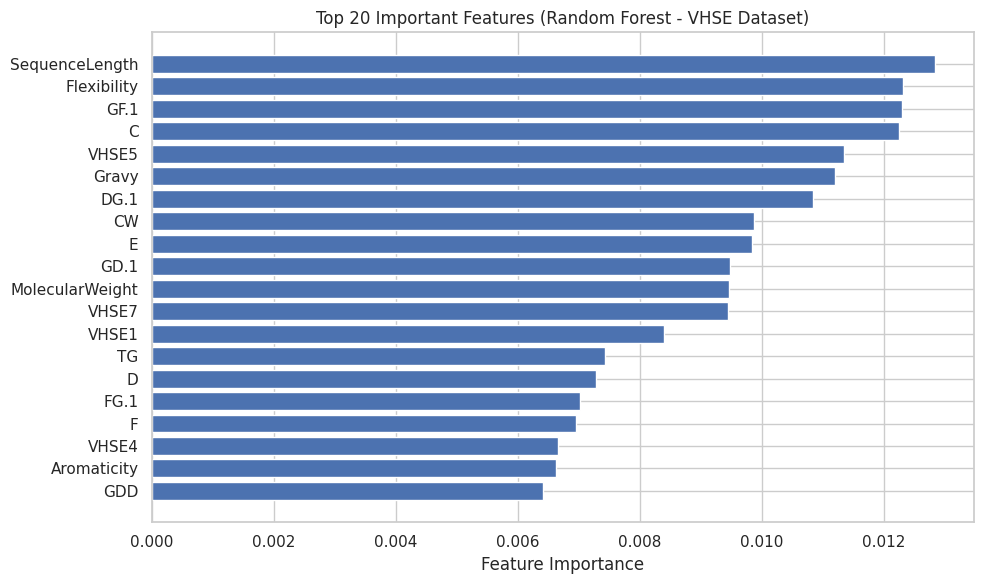

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Get the trained Random Forest model from your VHSE-trained models
rf_model_vhse = trained_vhse_models["RandomForest"]

# Extract feature importances and corresponding feature names
importances = rf_model_vhse.feature_importances_
feature_names = processed_custom.feature_names

# Sort and select top 20 features
indices = np.argsort(importances)[::-1]
top_n = 20
top_features = [feature_names[i] for i in indices[:top_n]]
top_importances = importances[indices[:top_n]]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances[::-1])
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features (Random Forest - VHSE Dataset)")
plt.tight_layout()
plt.show()

In [26]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Define SVM model and param grid
from sklearn.svm import SVC
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(
    SVC(probability=True),
    param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Run the grid search on VHSE dataset
grid_svm.fit(X_train_vhse, y_train_vhse)

# Print the best parameters
print("Best parameters found:", grid_svm.best_params_)
print("Best cross-validation score:", grid_svm.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/secondbook5/micromamba/envs/comp_drug_disc/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning:

Best parameters found: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.8217295276928305


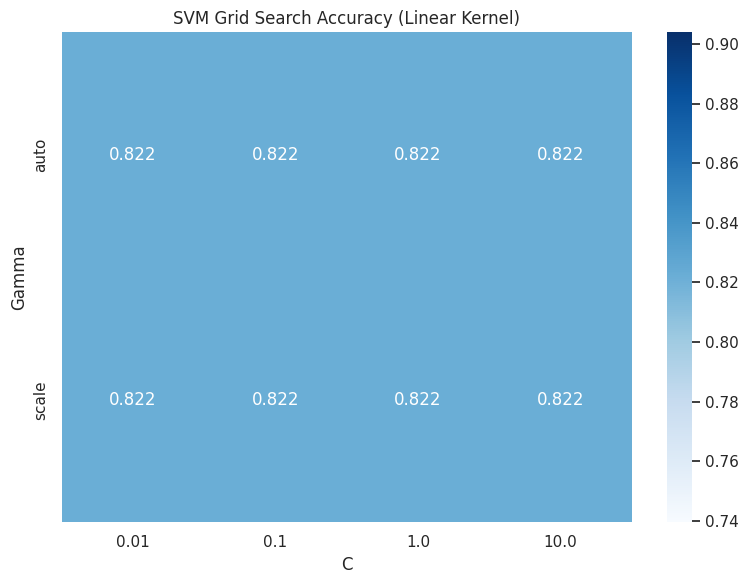

In [27]:
# Convert to DataFrame for visualization
results_df = pd.DataFrame(grid_svm.cv_results_)

# Filter for linear kernel
linear_df = results_df[results_df['param_kernel'] == 'linear']

# Pivot to plot heatmap of C vs gamma
pivot = linear_df.pivot_table(
    index='param_gamma',
    columns='param_C',
    values='mean_test_score'
)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='Blues', fmt=".3f")
plt.title("SVM Grid Search Accuracy (Linear Kernel)")
plt.xlabel("C")
plt.ylabel("Gamma")
plt.tight_layout()
plt.show()

# Evaluating model

### **Question 6: Evaluate your model**

**• Why is it important to evaluate and compare your model's performance across different evaluation metrics, such as accuracy, precision, recall, and F1 score, and what do these differences reveal about its strengths and weaknesses?**

Evaluating and comparing model performance across multiple metrics such as accuracy, precision, recall, and the F1 score provides a comprehensive understanding of the model’s behavior, especially in scenarios involving imbalanced datasets or multiple classes. Accuracy alone can be misleading, particularly when class distribution is uneven, as it treats all correct predictions equally regardless of class size. Precision indicates the proportion of true positive predictions among all positive predictions, thus highlighting the model's specificity and its tendency to avoid false positives. Recall measures the proportion of true positives captured among all actual positive instances, underscoring the model's sensitivity or completeness in capturing relevant cases. The F1 score, the harmonic mean of precision and recall, offers a balanced metric particularly valuable when seeking equilibrium between sensitivity and specificity. Analyzing these metrics collectively reveals deeper insights into the model’s strengths—such as excellent identification of certain classes—and weaknesses, such as its tendency to overlook rare but potentially important classes. Employing multiple metrics ensures a thorough evaluation of the model’s overall effectiveness and robustness.

**• If you were to visualize your model's evaluation results (e.g., with confusion matrices, ROC curves, or precision-recall plots), what insights could these visualizations provide about its classification capabilities?**

Visualizing the model's evaluation results through confusion matrices, ROC curves, or precision-recall plots can yield valuable qualitative and quantitative insights. A confusion matrix explicitly illustrates the specific patterns of misclassification by clearly displaying true positives, true negatives, false positives, and false negatives across classes, allowing for easy identification of classes the model struggles to differentiate. ROC curves illustrate the trade-off between sensitivity (true positive rate) and specificity (false positive rate), providing insights into the model’s overall discriminative ability across varying decision thresholds; the Area Under the ROC Curve (ROC-AUC) provides a concise, interpretable measure of model performance. Precision-recall plots specifically highlight performance in imbalanced settings by clearly displaying trade-offs between precision and recall, pinpointing potential issues in classifying minority or biologically critical classes effectively. Collectively, these visualizations enhance interpretability, highlight critical errors, and facilitate more informed adjustments and improvements to the model.

**• Suppose your model performs exceptionally well on the training set but poorly on the test set—how might you diagnose and address this discrepancy during the evaluation phase?**

If the model demonstrates exceptional performance on the training set but deteriorates significantly on the test set, this indicates a strong likelihood of overfitting. To diagnose this issue, a thorough evaluation including cross-validation and inspection of learning curves should be conducted. Learning curves can quickly illustrate divergence between training and validation accuracy or loss, confirming overfitting. Examining feature importances can also highlight whether the model relies heavily on noise or overly specific features from the training data. To address overfitting, regularization strategies such as adjusting hyperparameters (e.g., reducing tree depth, increasing minimum sample splits, or introducing regularization parameters), applying early stopping in iterative training methods, or simplifying feature selection may be beneficial. Expanding the dataset through augmentation, if possible, or using more robust validation techniques like stratified k-fold cross-validation, can also significantly mitigate the discrepancy and improve generalization.

**• If you needed to present the evaluation results of your model to a non-technical audience, how would you simplify the findings while ensuring they still convey the model's effectiveness?**

When presenting model evaluation results to a non-technical audience, it is crucial to simplify the findings into clear, intuitive language that conveys the effectiveness and reliability of the model without losing critical context. Rather than emphasizing complex statistical terms or metrics alone, the presentation should focus on practical outcomes—for instance, clearly stating the percentage of correct classifications or using analogies ("correctly identifying diseases 85 out of 100 times"). Visual tools such as simplified bar charts showing correct versus incorrect predictions, or easy-to-read pie charts representing overall accuracy, help convey performance intuitively. Using relatable analogies or comparisons (e.g., comparing the model to an expert who correctly identifies proteins at a certain accuracy rate) also helps communicate complex evaluation results effectively. Highlighting real-world implications, such as improved drug discovery rates or reduced costs due to fewer misclassifications, makes the evaluation relevant and comprehensible, ensuring the audience appreciates the model’s practical value.

In [28]:
from sklearn.metrics import accuracy_score


def evaluate_model(model, X_test, y_test, model_name: str):
    """
    Evaluates a single model on test data and prints accuracy.

    Args:
        model: Trained model object.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): True labels (encoded).
        model_name (str): Name of the model.

    Returns:
        np.ndarray: Predicted labels (encoded).
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n=== {model_name} ===")
    print(f"Accuracy for testing data: {accuracy:.4f}")
    return y_pred

In [29]:
def evaluate_model_dict(model_dict: dict, X_test: np.ndarray, y_test: np.ndarray, dataset_name: str):
    """
    Evaluates multiple models using the instructor-style evaluation function.

    Args:
        model_dict (dict): Dictionary of models.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): True labels (encoded).
        dataset_name (str): Either "Original" or "VHSE".
    """
    print(f"\n\n=== Evaluation Results: {dataset_name} Dataset ===")
    for model_name, model in model_dict.items():
        _ = evaluate_model(model, X_test, y_test, model_name=model_name)

In [30]:
X_test_orig = processed_original.X_test_scaled
y_test_orig = processed_original.y_test_encoded

X_test_vhse = processed_custom.X_test_scaled
y_test_vhse = processed_custom.y_test_encoded

In [31]:
# Evaluate models trained on the original features
evaluate_model_dict(
    model_dict=trained_original_models,
    X_test=X_test_orig,
    y_test=y_test_orig,
    dataset_name="Original"
)

# Evaluate models trained on the VHSE features
evaluate_model_dict(
    model_dict=trained_vhse_models,
    X_test=X_test_vhse,
    y_test=y_test_vhse,
    dataset_name="VHSE"
)



=== Evaluation Results: Original Dataset ===

=== RandomModel ===
Accuracy for testing data: 0.1241

=== LogisticRegression ===
Accuracy for testing data: 0.6861

=== RandomForest ===
Accuracy for testing data: 0.7299

=== SVM ===
Accuracy for testing data: 0.7810

=== KNN ===
Accuracy for testing data: 0.5766


=== Evaluation Results: VHSE Dataset ===

=== RandomModel ===
Accuracy for testing data: 0.1387

=== LogisticRegression ===
Accuracy for testing data: 0.8613

=== RandomForest ===
Accuracy for testing data: 0.7445

=== SVM ===
Accuracy for testing data: 0.8467

=== KNN ===
Accuracy for testing data: 0.4453


In [32]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np


def evaluate_model_full(model, X_test: np.ndarray, y_test: np.ndarray, model_name: str, label_encoder=None) -> None:
    print(f"\n--- {model_name} ---")
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred,
          target_names=label_encoder.classes_ if label_encoder else None))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        try:
            auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
            print("ROC-AUC:", auc)
        except ValueError:
            print("ROC-AUC could not be calculated.")


def evaluate_model_dict_full(model_dict: dict, X_test: np.ndarray, y_test: np.ndarray, dataset_name: str, label_encoder=None) -> None:
    print(f"\n\n=== Full Evaluation: {dataset_name} Dataset ===")
    for name, model in model_dict.items():
        evaluate_model_full(model, X_test, y_test,
                            model_name=name, label_encoder=label_encoder)

In [33]:
evaluate_model_dict_full(
    trained_original_models,
    processed_original.X_test_scaled,
    processed_original.y_test_encoded,
    dataset_name="Original",
    label_encoder=processed_original.label_encoder
)

evaluate_model_dict_full(
    trained_vhse_models,
    processed_custom.X_test_scaled,
    processed_custom.y_test_encoded,
    dataset_name="VHSE",
    label_encoder=processed_custom.label_encoder
)



=== Full Evaluation: Original Dataset ===

--- RandomModel ---
Classification Report:
              precision    recall  f1-score   support

      ATPase       0.00      0.00      0.00        13
   Aquaporin       0.15      0.67      0.25         3
     Channel       0.22      0.07      0.11        29
        GPCR       0.08      0.03      0.05        29
    Integrin       0.00      0.00      0.00         4
         MHC       0.13      0.22      0.17         9
 Phosphatase       0.00      0.00      0.00        11
    Protease       0.24      0.25      0.24        16
         RTK       0.00      0.00      0.00        13
     Ser:Thr       0.08      0.10      0.09        10

    accuracy                           0.09       137
   macro avg       0.09      0.13      0.09       137
weighted avg       0.11      0.09      0.08       137

Accuracy: 0.08759124087591241

--- LogisticRegression ---
Classification Report:
              precision    recall  f1-score   support

      ATPase     

In [34]:
def cross_validate_models(models: dict, X_train: np.ndarray, y_train: np.ndarray, cv: int = 5) -> dict:
    print("\n=== Cross-Validation Scores ===")
    scores = {}
    for name, model in models.items():
        print(f"\n{name}")
        try:
            cv_scores = cross_val_score(
                model, X_train, y_train, cv=cv, scoring='accuracy')
            print(
                f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
            scores[name] = cv_scores
        except Exception as e:
            print(f"Error in CV for {name}: {e}")
    return scores

In [35]:
cv_scores_original = cross_validate_models(
    trained_original_models,
    processed_original.X_train_scaled,
    processed_original.y_train_encoded
)

cv_scores_vhse = cross_validate_models(
    trained_vhse_models,
    processed_custom.X_train_scaled,
    processed_custom.y_train_encoded
)


=== Cross-Validation Scores ===

RandomModel
Error in CV for RandomModel: Cannot clone object '<__main__.random_model object at 0x7fd02c42c0a0>' (type <class '__main__.random_model'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

LogisticRegression


Mean CV Accuracy: 0.7372 (+/- 0.0232)

RandomForest
Mean CV Accuracy: 0.7537 (+/- 0.0327)

SVM
Mean CV Accuracy: 0.7335 (+/- 0.0402)

KNN
Mean CV Accuracy: 0.5773 (+/- 0.0524)

=== Cross-Validation Scores ===

RandomModel
Error in CV for RandomModel: Cannot clone object '<__main__.random_model object at 0x7fd02c42c100>' (type <class '__main__.random_model'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

LogisticRegression
Mean CV Accuracy: 0.8401 (+/- 0.0291)

RandomForest
Mean CV Accuracy: 0.7537 (+/- 0.0327)

SVM
Mean CV Accuracy: 0.8217 (+/- 0.0194)

KNN
Mean CV Accuracy: 0.4560 (+/- 0.0502)


In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


def plot_multiclass_roc(models: dict, X_test: np.ndarray, y_test: np.ndarray,
                        class_names: list[str], dataset_name: str = "Dataset") -> None:
    """
    Plots multi-class ROC curves for all models that support `predict_proba`.

    Args:
        models (dict): Trained model dictionary.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): Encoded test labels.
        class_names (list[str]): Class names corresponding to y.
        dataset_name (str): Label for output title.
    """
    n_classes = len(class_names)
    y_bin = label_binarize(y_test, classes=range(n_classes))

    plt.figure(figsize=(12, 8))
    for name, model in models.items():
        if not hasattr(model, "predict_proba"):
            continue  # Skip models that don’t support predict_proba
        try:
            y_score = model.predict_proba(X_test)
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            # Compute average macro-ROC
            all_fpr = np.unique(np.concatenate(
                [fpr[i] for i in range(n_classes)]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= n_classes
            macro_auc = auc(all_fpr, mean_tpr)

            plt.plot(all_fpr, mean_tpr,
                     label=f"{name} (macro AUC = {macro_auc:.2f})")

        except Exception as e:
            print(f"Error plotting ROC for {name}: {e}")

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title(f"Multiclass ROC Curves: {dataset_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

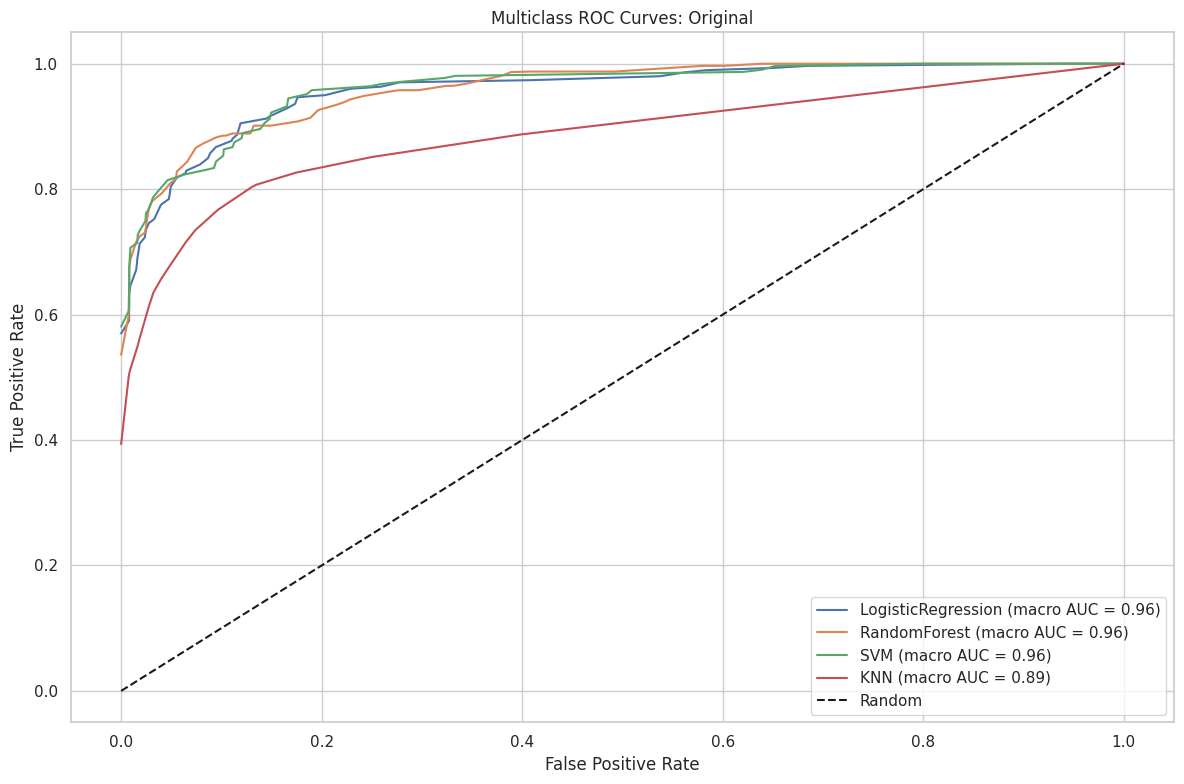

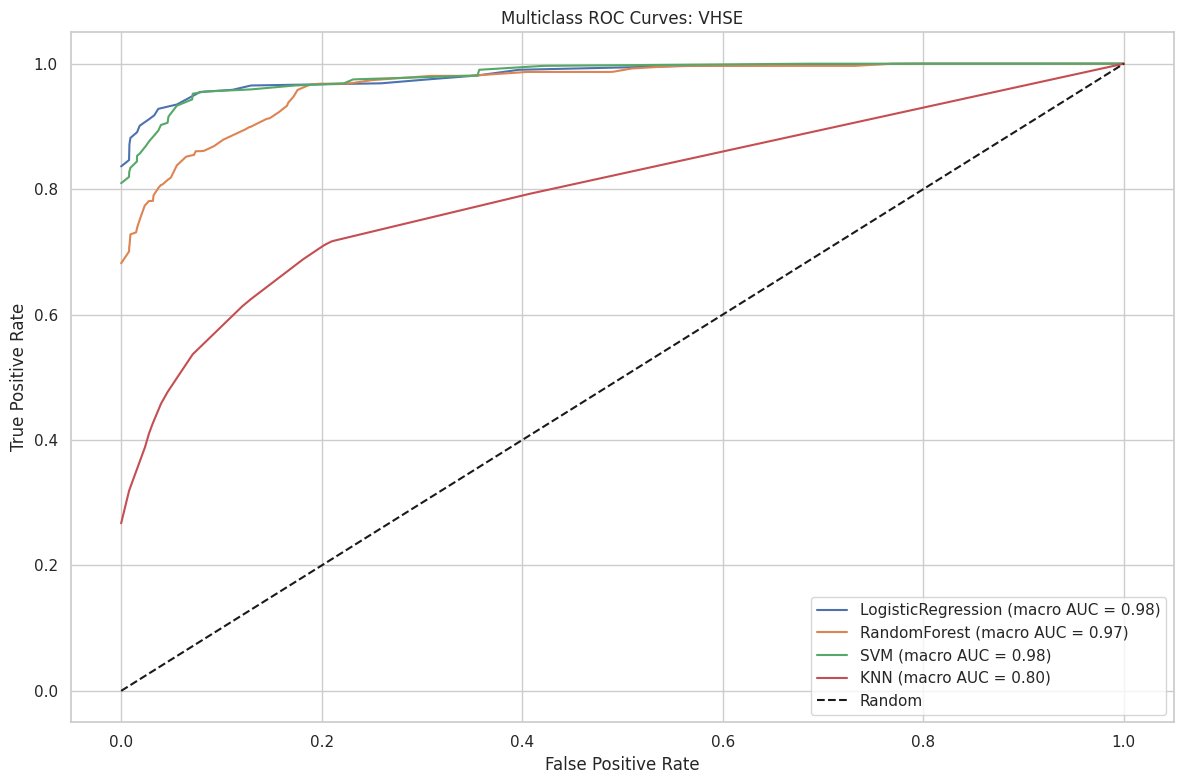

In [37]:
# Class names used for plotting
class_names = ['ATPase', 'Aquaporin', 'Channel', 'GPCR', 'Integrin',
               'MHC', 'Phosphatase', 'Protease', 'RTK', 'Ser:Thr']

# Plot for Original
plot_multiclass_roc(trained_original_models,
                    processed_original.X_test_scaled,
                    processed_original.y_test_encoded,
                    class_names,
                    dataset_name="Original")

# Plot for VHSE
plot_multiclass_roc(trained_vhse_models,
                    processed_custom.X_test_scaled,
                    processed_custom.y_test_encoded,
                    class_names,
                    dataset_name="VHSE")

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(model, X_test: np.ndarray, y_test: np.ndarray,
                          class_names: list[str], model_name: str, dataset_name: str):
    """
    Plots a labeled confusion matrix for a given model and test set.

    Args:
        model: Trained classifier with a `.predict()` method.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): True labels (encoded).
        class_names (list[str]): Class names in the same order as label encoding.
        model_name (str): Name of the classifier.
        dataset_name (str): "Original" or "VHSE" dataset name.
    """
    # Step 1: Predict labels
    y_pred = model.predict(X_test)

    # Step 2: Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Step 3: Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name} on {dataset_name} Dataset')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

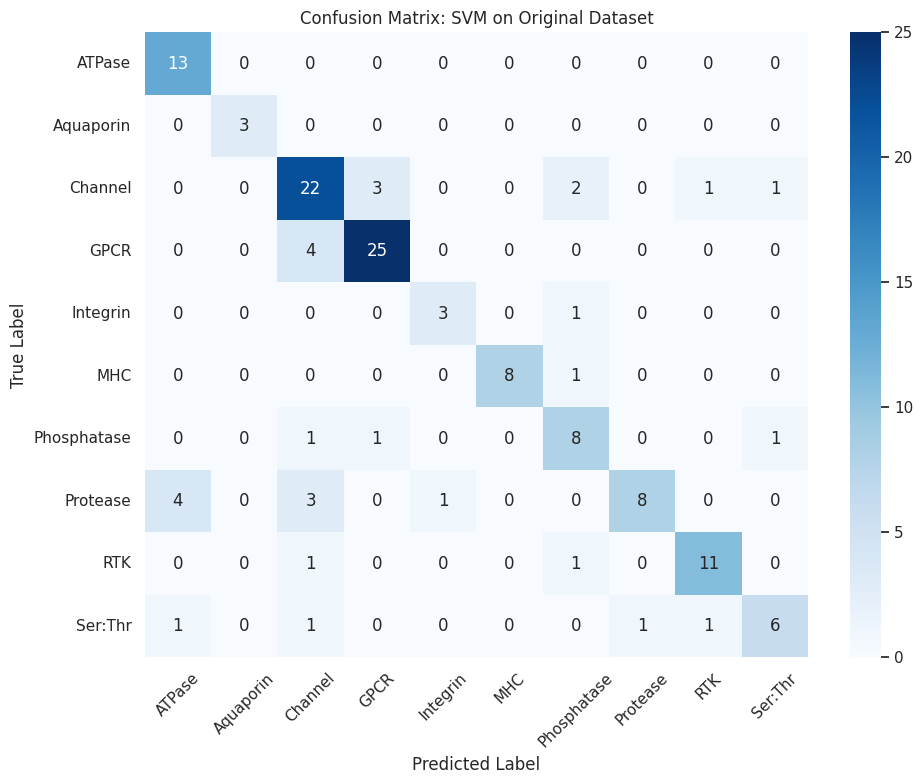

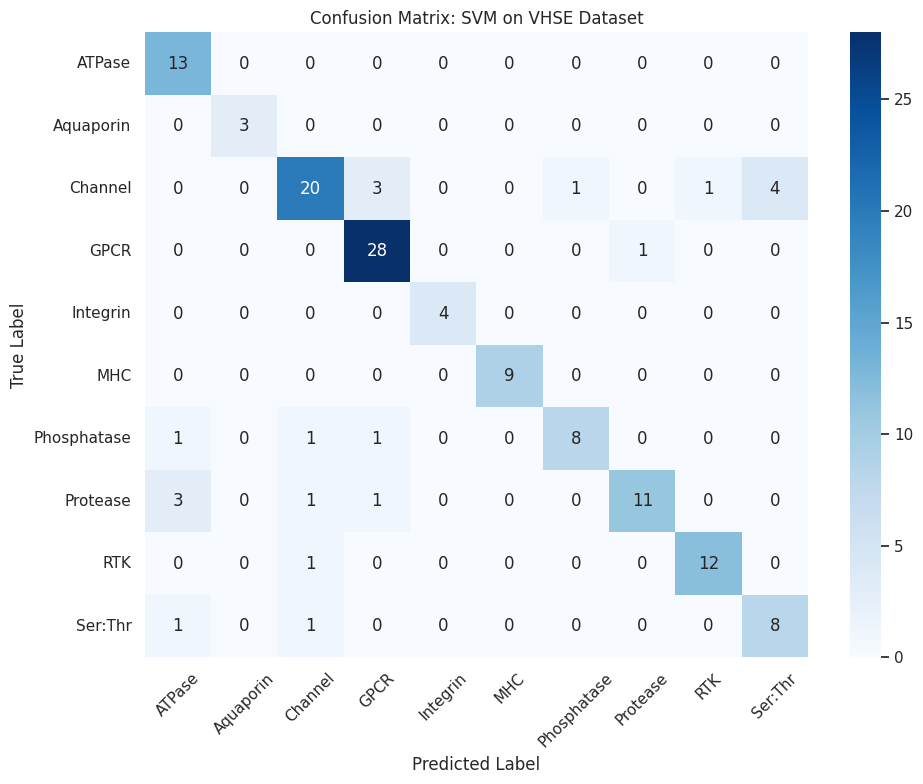

In [39]:
# Class labels (must match LabelEncoder order)
class_names = processed_original.label_encoder.classes_.tolist()

# Plot for Original dataset (SVM)
plot_confusion_matrix(trained_original_models["SVM"],
                      processed_original.X_test_scaled,
                      processed_original.y_test_encoded,
                      class_names,
                      model_name="SVM",
                      dataset_name="Original")

# Plot for VHSE dataset (SVM)
plot_confusion_matrix(trained_vhse_models["SVM"],
                      processed_custom.X_test_scaled,
                      processed_custom.y_test_encoded,
                      class_names,
                      model_name="SVM",
                      dataset_name="VHSE")

# Save Format

In [40]:
def save_predictions(_fn, _y_pred, _df):
    import csv
    with open(_fn, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', lineterminator='\n')
        writer.writerow(['Entry', 'ProteinClass'])
        for y, Entry in zip(_df['Entry'], _y_pred):
            writer.writerow([y, Entry])

In [41]:
# Step 1: Use the best model (e.g., SVM on VHSE dataset)
best_model = trained_vhse_models["SVM"]

# Step 2: Predict labels on VHSE test set
y_pred_vhse = best_model.predict(processed_custom.X_test_scaled)

# Step 3: Decode the predicted labels back to class names
y_pred_vhse_labels = processed_custom.label_encoder.inverse_transform(
    y_pred_vhse)

# Step 4: Restore Entry column from test DataFrame
X_test_with_entry = processed_custom.X_test.copy()
X_test_with_entry['Entry'] = Dataset_vhse.loc[X_test_with_entry.index, 'Entry']

# Step 5: Save final predictions in challenge format
save_predictions("vhse_predictions.csv", y_pred_vhse_labels, X_test_with_entry)

# References
- Mei, H., Liao, Z. H., Zhou, Y., & Li, S. Z. (2005). A new set of amino acid descriptors and its application in peptide QSARs. Biopolymers, 80(6), 775–786. https://doi.org/10.1002/bip.20296

- van Westen, G. J., Swier, R. F., Wegner, J. K., Ijzerman, A. P., van Vlijmen, H. W., & Bender, A. (2013). Benchmarking of protein descriptor sets in proteochemometric modeling (part 1): comparative study of 13 amino acid descriptor sets. Journal of cheminformatics, 5(1), 41. https://doi.org/10.1186/1758-2946-5-41

- van Westen, G. J., Swier, R. F., Cortes-Ciriano, I., Wegner, J. K., Overington, J. P., Ijzerman, A. P., van Vlijmen, H. W., & Bender, A. (2013). Benchmarking of protein descriptor sets in proteochemometric modeling (part 2): modeling performance of 13 amino acid descriptor sets. Journal of cheminformatics, 5(1), 42. https://doi.org/10.1186/1758-2946-5-42 

- Xu, Y., Verma, D., Sheridan, R. P., Liaw, A., Ma, J., Marshall, N. M., McIntosh, J., Sherer, E. C., Svetnik, V., & Johnston, J. M. (2020). Deep Dive into Machine Learning Models for Protein Engineering. Journal of chemical information and modeling, 60(6), 2773–2790. https://doi.org/10.1021/acs.jcim.0c00073 